<a href="https://colab.research.google.com/github/Lim-Calculus/Deep-Learning-Based-Semantic-Segmentation-with-PyTorch-and-ONNX/blob/main/Deep_Learning_Based_Semantic_Segmentation_with_PyTorch_and_ONNX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
This project involves training and developing a deep learning-based semantic segmentation model using the PyTorch framework. Once the model is trained, it will be converted to the ONNX format. The converted ONNX model will then be used for inference with ONNX Runtime.

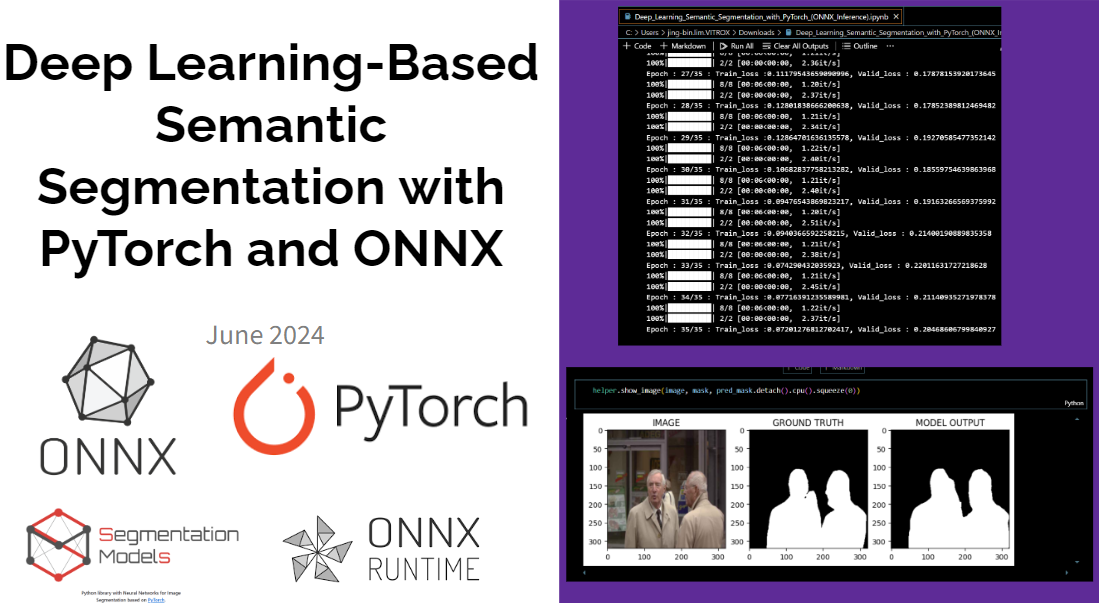

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch torch torchvision
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!pip3 install onnx onnxruntime

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-yd9e3l22
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-yd9e3l22
  Resolved https://github.com/albumentations-team/albumentations to commit 30ac95ea943a6ff8824e34b4ef4b0954e8a3d6b6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


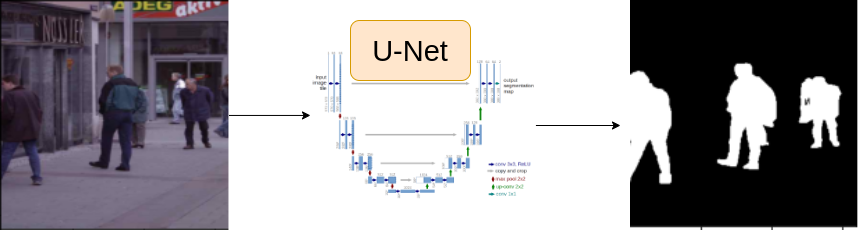

# Some Common Imports

In [3]:
import sys
sys.path.append('Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import Dataset
import helper
import onnx
import onnxruntime

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '.'

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")

EPOCHS = 60
LR = 1e-3
IMG_SIZE = 320
BATCH_SIZE = 32

ENCODER = 'timm-mobilenetv3_large_100'
WEIGHTS = 'imagenet'

Using cuda device


In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]
image_path  = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


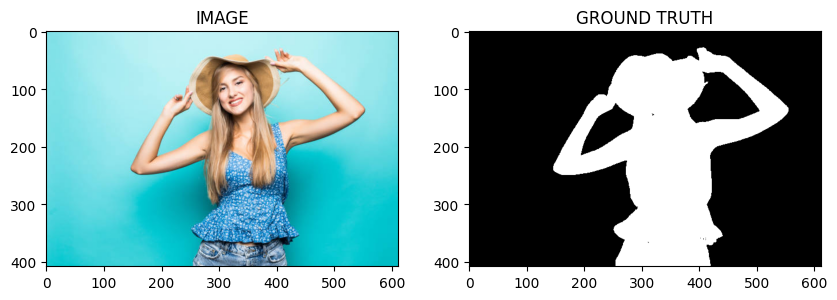

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w,c)
    if mask.ndim == 2:
      mask = np.expand_dims(mask, axis=-1)

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    image = np.reshape(image, (IMG_SIZE, IMG_SIZE, 3))
    mask = np.reshape(mask, (IMG_SIZE, IMG_SIZE, 1))

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.reshape(image, (IMG_SIZE, IMG_SIZE, 3))
    mask = np.reshape(mask, (IMG_SIZE, IMG_SIZE, 1))

    #(h,w,c) -> (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)
    return image, mask




In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


torch.Size([3, 320, 320]) torch.Size([1, 320, 320])


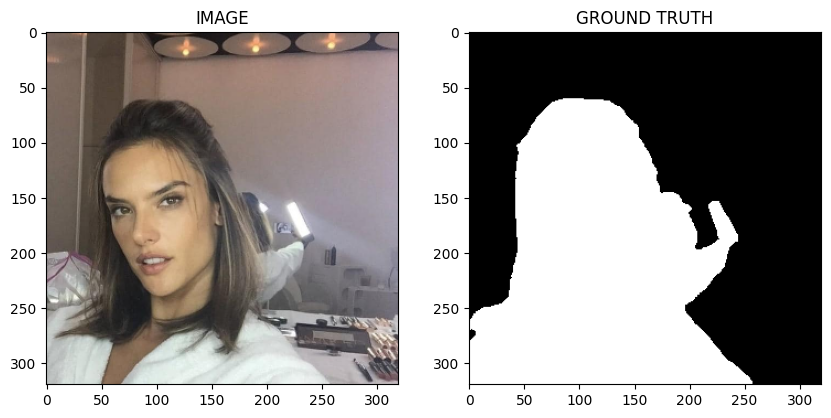

In [16]:
idx = 1
image, mask = trainset[idx]
print(image.shape, mask.shape)
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f"Total no of Batches in trainloader : {len(trainloader)}")
print(f"Total no of Batches in validloader : {len(validloader)}")

Total no of Batches in trainloader : 8
Total no of Batches in validloader : 2


In [20]:
for image, mask in trainloader:
    break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')

One batch image shape : torch.Size([32, 3, 320, 320])
One batch mask shape : torch.Size([32, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None ##output logits
        )

    def forward(self, images, masks = None):

        logits = self.arc(images)

        if masks is not None:
            loss1 = DiceLoss(mode = 'binary', from_logits=True)(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_large_100-427764d5.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_large_100-427764d5.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 186MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): MobileNetV3Encoder(
      (model): MobileNetV3Features(
        (conv_stem): Conv2dSame(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Hardswish()
        (blocks): Sequential(
          (0): Sequential(
            (0): DepthwiseSeparableConv(
              (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (bn1): BatchNormAct2d(
                16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): ReLU(inplace=True)
              )
              (se): Identity()
              (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn2): BatchNormAct2d(
                16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
                (drop):

# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [25]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, cooldown=0, min_lr=1e-7)

In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("SAVED-MODEL")
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1}/{EPOCHS} : Train_loss :{train_loss}, Valid_loss : {valid_loss}")

 88%|████████▊ | 7/8 [00:10<00:01,  1.40s/it]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


SAVED-MODEL
Epoch : 1/60 : Train_loss :1.2288507297635078, Valid_loss : 1.3855148553848267


100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


SAVED-MODEL
Epoch : 2/60 : Train_loss :0.77512326836586, Valid_loss : 0.5074732452630997


100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


SAVED-MODEL
Epoch : 3/60 : Train_loss :0.4322342574596405, Valid_loss : 0.2849167287349701


100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


Epoch : 4/60 : Train_loss :0.3058362677693367, Valid_loss : 0.32719334959983826


100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


SAVED-MODEL
Epoch : 5/60 : Train_loss :0.2257970403879881, Valid_loss : 0.2506185248494148


100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


SAVED-MODEL
Epoch : 6/60 : Train_loss :0.19896588660776615, Valid_loss : 0.22349263727664948


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Epoch : 7/60 : Train_loss :0.1703112106770277, Valid_loss : 0.23073022812604904


100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


SAVED-MODEL
Epoch : 8/60 : Train_loss :0.16321812383830547, Valid_loss : 0.2073753923177719


100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


SAVED-MODEL
Epoch : 9/60 : Train_loss :0.14115777984261513, Valid_loss : 0.20302172005176544


100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch : 10/60 : Train_loss :0.13735217973589897, Valid_loss : 0.21091371774673462


100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch : 11/60 : Train_loss :0.11570117436349392, Valid_loss : 0.21099799871444702


100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


SAVED-MODEL
Epoch : 12/60 : Train_loss :0.11039980314671993, Valid_loss : 0.18018141388893127


100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


SAVED-MODEL
Epoch : 13/60 : Train_loss :0.111263164319098, Valid_loss : 0.16869162768125534


100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


SAVED-MODEL
Epoch : 14/60 : Train_loss :0.11402946431189775, Valid_loss : 0.16839560121297836


100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch : 15/60 : Train_loss :0.10921081993728876, Valid_loss : 0.17857712507247925


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


Epoch : 16/60 : Train_loss :0.093297497369349, Valid_loss : 0.18150727450847626


100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch : 17/60 : Train_loss :0.08592358138412237, Valid_loss : 0.17392464727163315


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


Epoch : 18/60 : Train_loss :0.08526436798274517, Valid_loss : 0.17218873649835587


100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


Epoch : 19/60 : Train_loss :0.0799255333840847, Valid_loss : 0.16952194273471832


100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


SAVED-MODEL
Epoch : 20/60 : Train_loss :0.08012345153838396, Valid_loss : 0.15411292761564255


100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


SAVED-MODEL
Epoch : 21/60 : Train_loss :0.07986282790079713, Valid_loss : 0.14765917509794235


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


Epoch : 22/60 : Train_loss :0.07474514422938228, Valid_loss : 0.15825187414884567


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch : 23/60 : Train_loss :0.06739144073799253, Valid_loss : 0.15251453965902328


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch : 24/60 : Train_loss :0.063519187271595, Valid_loss : 0.15650585293769836


100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


Epoch : 25/60 : Train_loss :0.07027326058596373, Valid_loss : 0.15670880675315857


100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


Epoch : 26/60 : Train_loss :0.06567642698064446, Valid_loss : 0.1550009399652481


100%|██████████| 2/2 [00:00<00:00,  3.14it/s]


SAVED-MODEL
Epoch : 27/60 : Train_loss :0.07131475815549493, Valid_loss : 0.1433386653661728


100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


SAVED-MODEL
Epoch : 28/60 : Train_loss :0.060506615322083235, Valid_loss : 0.1360277682542801


100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


SAVED-MODEL
Epoch : 29/60 : Train_loss :0.06723282346501946, Valid_loss : 0.13440054655075073


100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch : 30/60 : Train_loss :0.06864326493814588, Valid_loss : 0.194887213408947


100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch : 31/60 : Train_loss :0.06122635817155242, Valid_loss : 0.1630784124135971


100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Epoch : 32/60 : Train_loss :0.06252559879794717, Valid_loss : 0.1489967182278633


100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch : 33/60 : Train_loss :0.06214401964098215, Valid_loss : 0.17139728367328644


100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Epoch : 34/60 : Train_loss :0.06398815661668777, Valid_loss : 0.17022661864757538


100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch : 35/60 : Train_loss :0.07711981981992722, Valid_loss : 0.18237993866205215


100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch : 36/60 : Train_loss :0.0674597704783082, Valid_loss : 0.21361858397722244


100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


Epoch : 37/60 : Train_loss :0.06192475697025657, Valid_loss : 0.1935126781463623


100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


Epoch : 38/60 : Train_loss :0.0716431112959981, Valid_loss : 0.30562591552734375


100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch : 39/60 : Train_loss :0.07975744362920523, Valid_loss : 0.22246406972408295


100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch : 40/60 : Train_loss :0.0660817502066493, Valid_loss : 0.18443716317415237


100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


Epoch : 41/60 : Train_loss :0.05963671673089266, Valid_loss : 0.21383322775363922


100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch : 42/60 : Train_loss :0.1316610872745514, Valid_loss : 0.2265273779630661


100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Epoch : 43/60 : Train_loss :0.1264796368777752, Valid_loss : 0.4091451168060303


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Epoch : 44/60 : Train_loss :0.13586574979126453, Valid_loss : 0.17095337808132172


100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


Epoch : 45/60 : Train_loss :0.08863148279488087, Valid_loss : 0.18726074695587158


100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch : 46/60 : Train_loss :0.09495621360838413, Valid_loss : 0.21716294437646866


100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


Epoch : 47/60 : Train_loss :0.08965020207688212, Valid_loss : 0.1970045119524002


100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


Epoch : 48/60 : Train_loss :0.09025307884439826, Valid_loss : 0.18772383034229279


100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch : 49/60 : Train_loss :0.07071925373747945, Valid_loss : 0.18825846910476685


100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


Epoch : 50/60 : Train_loss :0.06388389924541116, Valid_loss : 0.1736438348889351


100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


Epoch : 51/60 : Train_loss :0.05656975321471691, Valid_loss : 0.1617562100291252


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


Epoch : 52/60 : Train_loss :0.05556068290024996, Valid_loss : 0.15197578817605972


100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


Epoch : 53/60 : Train_loss :0.05205071158707142, Valid_loss : 0.15141735970973969


100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch : 54/60 : Train_loss :0.04963409900665283, Valid_loss : 0.1566845178604126


100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


Epoch : 55/60 : Train_loss :0.052100326865911484, Valid_loss : 0.17476946860551834


100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


Epoch : 56/60 : Train_loss :0.04887794703245163, Valid_loss : 0.18918968737125397


100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch : 57/60 : Train_loss :0.04951492976397276, Valid_loss : 0.19413979351520538


100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


Epoch : 58/60 : Train_loss :0.04704667814075947, Valid_loss : 0.18699750304222107


100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


Epoch : 59/60 : Train_loss :0.04595752106979489, Valid_loss : 0.16804568469524384


100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

Epoch : 60/60 : Train_loss :0.04519381606951356, Valid_loss : 0.15300261974334717


# Task 9 : Inference

In [28]:
idx = 50

model.load_state_dict(torch.load('best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)* 1.0

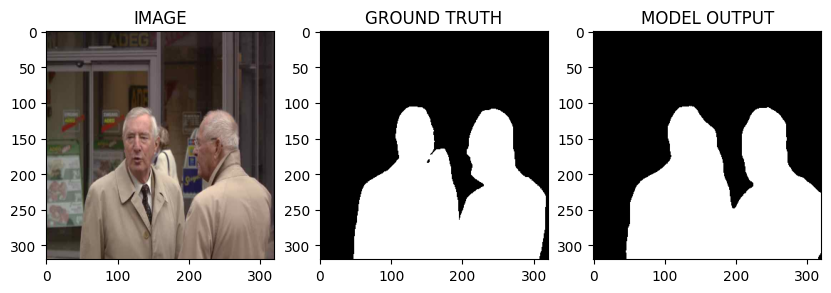

In [29]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

## Convert to ONNX

In [31]:
## Export to ONNX
# Input to the model
onnx_dynamic_batch_size = 2
x = torch.randn(onnx_dynamic_batch_size, 3, IMG_SIZE, IMG_SIZE, requires_grad=True)
model.to('cpu')
torch_out = model(x.to('cpu'))
model.eval()
# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "segmentation.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to  # Increase opset version to 11
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}}
                 )

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


## Inference in ONNX

In [32]:
onnx_model = onnx.load("segmentation.onnx")
onnx.checker.check_model(onnx_model)

In [33]:
ort_session = onnxruntime.InferenceSession("segmentation.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [40]:
def onnx_inference(onnx_model_filepath, image):
  onnx_model = onnx.load(onnx_model_filepath)
  onnx.checker.check_model(onnx_model) # Check ONNX Model
  ort_session = onnxruntime.InferenceSession(onnx_model_filepath, providers=["CPUExecutionProvider"])

  # compute ONNX Runtime output prediction
  ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(image.unsqueeze(0))}
  ort_outs = ort_session.run(None, ort_inputs)
  img_out_y = ort_outs[0]
  pred_mask = torch.sigmoid(torch.Tensor(img_out_y))
  pred_mask = (pred_mask > 0.5)* 1.0
  return pred_mask.detach().cpu().squeeze(0)



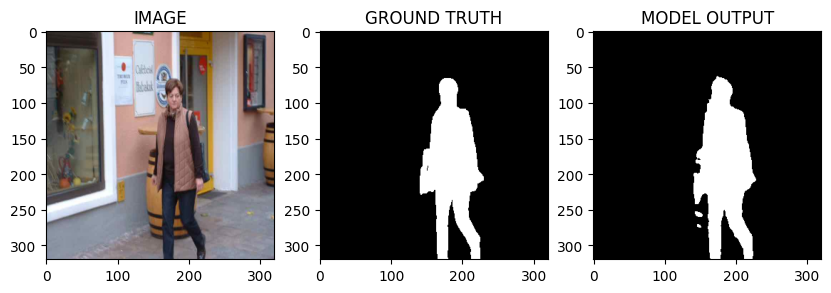

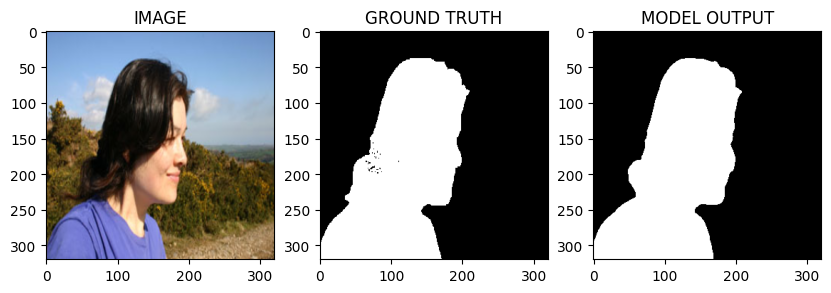

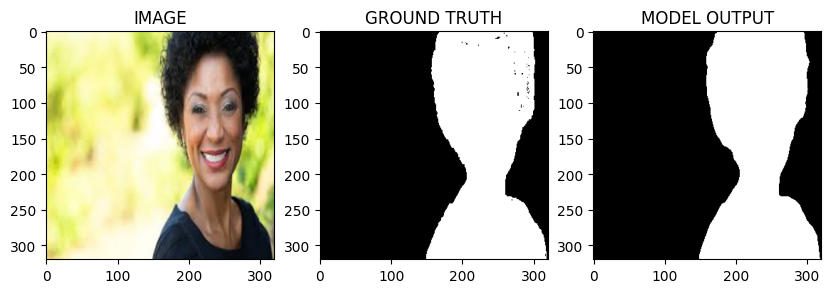

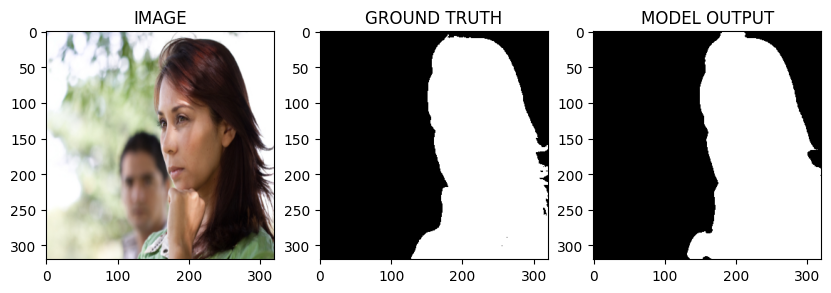

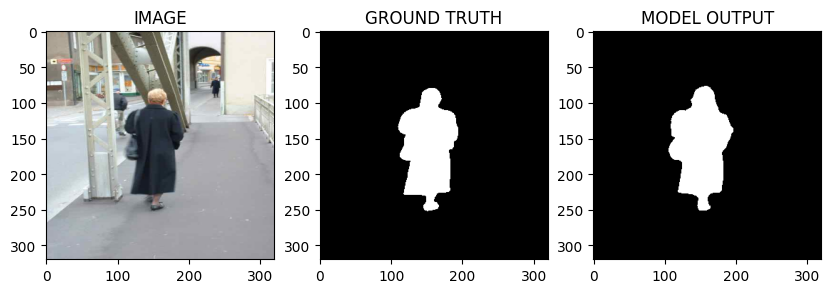

In [42]:
for idx in range(5):
  image, mask = validset[idx]
  pred_mask = onnx_inference('segmentation.onnx', image)
  helper.show_image(image, mask, pred_mask)

